**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Ingenieria de características**

Tecnológico de Monterrey



DATOS CRUDOS - DATOS PARA ML
* Generación de nuevas características
* Discretización o binning
* Codificación (ordinal, one hot,…)
* Escalamiento (normalización, estandarización, min – max,…)
* Transformación (logarítmica, exponencial, raíz cuadrada, Box – Cox, Yeo – Johnson,…)

METODOS DE FILTRADO

* Umbral de varianza
* Correlación
* Chi-cuadrado
* ANOVA
* Análisis de componentes principales (PCA)
* Análisis factorial (FA)

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

In [185]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [186]:
seminuevos_fe_df = pd.read_csv("/content/drive/MyDrive/MONTE DE PIEDAD - AUTOAVANZA INTERNA/SCRAPE/dataset_seminuevos-scrape_fe.csv")

In [187]:
seminuevos_fe_df.head()

,carroceria,color,combustible,fecha,marca,precio,odometro_clean
0,Coupé,Amarillo,Gasolina,2015.0,Mercedes Benz,1990000.0,25200.0000
1,Camioneta SUV,Blanco,Gasolina,2017.0,GMC,450000.0,120000.0000
2,Camioneta SUV,Blanco,Gasolina,2006.0,Ford,105000.0,229540.1642
3,Hatchback (5 Puertas),Blanco,Gasolina,2015.0,Nissan,138500.0,95000.0000
4,Camioneta SUV,Blanco,Gasolina,2020.0,Audi,629000.0,50000.0000


In [188]:
seminuevos_fe_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
carroceria,8723,20,Camioneta SUV,3866,NaN,NaN,NaN,NaN,NaN,NaN,NaN
color,8723,46,Blanco,3936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
combustible,8723,4,Gasolina,8274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fecha,8723.0,NaN,NaN,NaN,2019.330391,4.101608,1968.0,2017.0,2020.0,2022.0,2026.0
marca,8723,66,Chevrolet,932,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precio,8723.0,NaN,NaN,NaN,507776.963889,3928185.102303,30000.0,269000.0,369850.0,540000.0,365990000.0
odometro_clean,8723.0,NaN,NaN,NaN,62416.585163,50257.508922,0.0,32696.5,60000.0,85000.0,1751667.0


In [189]:
seminuevos_fe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8723 entries, 0 to 8722
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carroceria      8723 non-null   object 
 1   color           8723 non-null   object 
 2   combustible     8723 non-null   object 
 3   fecha           8723 non-null   float64
 4   marca           8723 non-null   object 
 5   precio          8723 non-null   float64
 6   odometro_clean  8723 non-null   float64
dtypes: float64(3), object(4)
memory usage: 477.2+ KB


# **Parte 1**. Preprocesamiento

In [190]:
Cantidad_filas = len(seminuevos_fe_df)
print('Cantidad de registros en el dataframe: ' + str(Cantidad_filas))

Cantidad_columnas = len(seminuevos_fe_df.columns)
print('Cantidad de columnas en el dataframe: ' + str(Cantidad_columnas))

Cantidad de registros en el dataframe: 8723
Cantidad de columnas en el dataframe: 7


In [191]:
numerical_columns = seminuevos_fe_df.select_dtypes(include=[np.number]).columns
categorical_columns =seminuevos_fe_df.select_dtypes(include=['object']).columns

# PARTE 1. PREPROCESAMIENTO NUMERICAS

## Valores atípicos

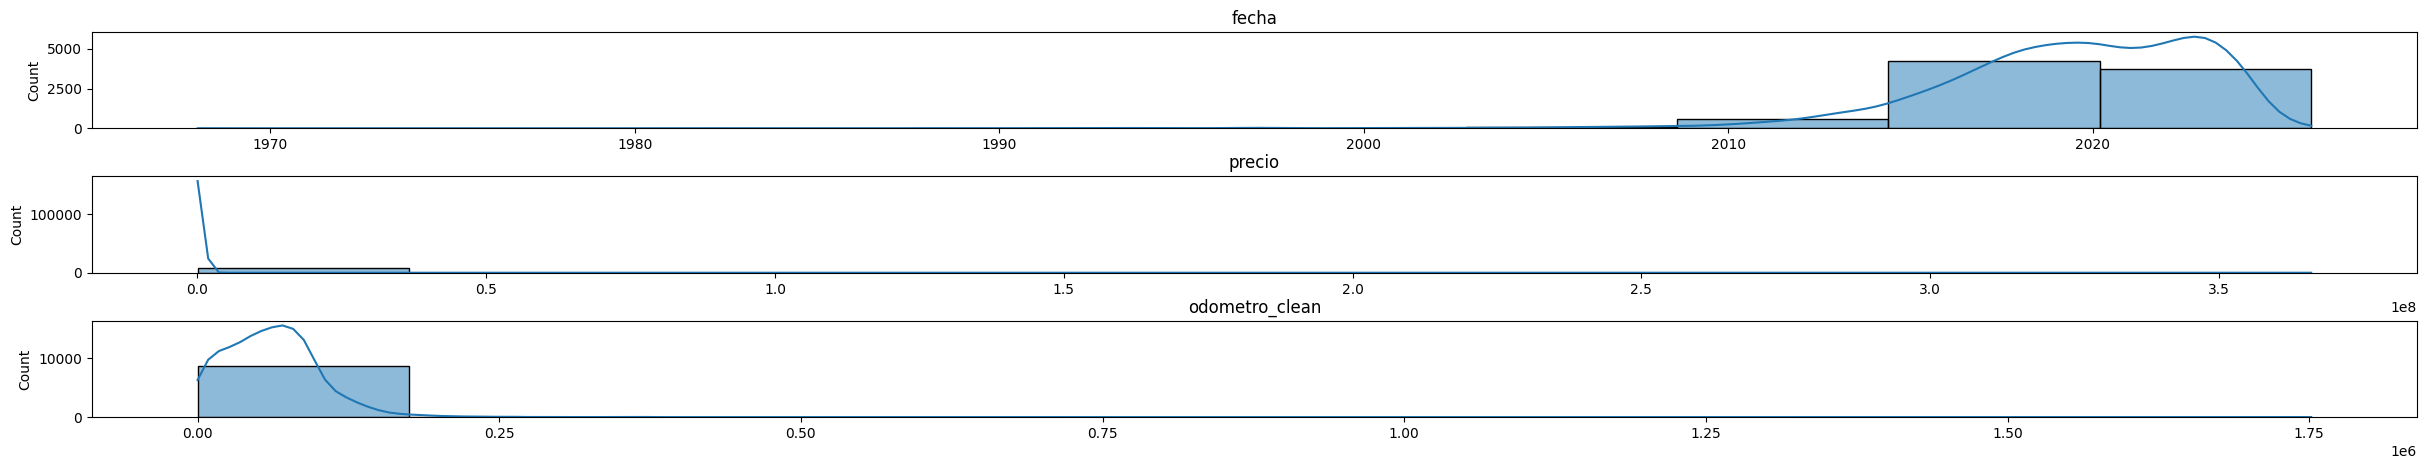

In [192]:
# Visualización de variables numéricas - Histogramas
fig, axes = plt.subplots(3,1, figsize = (30,5))
plt.subplots_adjust(wspace=0.3, hspace = 0.5)
axes = axes.ravel()

for col, ax in zip(seminuevos_fe_df[numerical_columns], axes):
  sns.histplot(x = seminuevos_fe_df[col], ax = ax, bins = 10, kde = True)
  ax.set(title = f'{col}', xlabel = None)

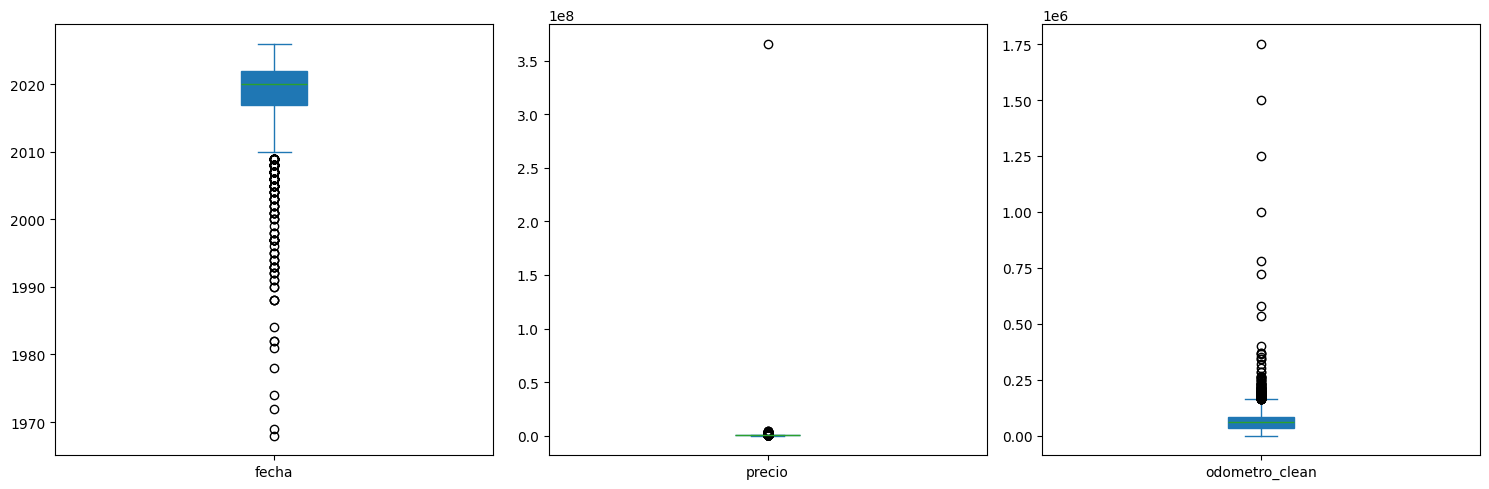

In [193]:
box_cols = seminuevos_fe_df[numerical_columns]

fig, axes = plt.subplots(1, len(numerical_columns), figsize=(5 * len(numerical_columns), 5))
axes = axes.ravel()

for col, ax in zip(numerical_columns, axes):
    box_cols[col].plot(kind='box', ax=ax, patch_artist=True)

plt.tight_layout()
plt.show()

Definitivamente hay outliers en las tres variables numericas vemos de que tamaño es el problema. En teoria 5% todavía podria permitirse si sabemos la razón.

In [194]:
seminuevos_fe_df.shape

(8723, 7)

**BINNING FECHA EN RANGOS**

In [195]:
seminuevos_fe_df['precio'].value_counts().sort_index() #CAPAZ VALE LA PENA NOMAS PONER UN LIMITE EN PRECIO

,count
precio,
30000.0,1
49000.0,1
49900.0,1
54564.0,1
63800.0,1
...,...
3500000.0,1
3900000.0,1
3999500.0,1


In [196]:
#box_cols = seminuevos_fe_df[numerical_columns] #AQUI YA NO APARECERIA FECHA

box_cols = ['precio', 'odometro_clean']

for col in box_cols:
    Q1 = seminuevos_fe_df[col].quantile(0.25)
    Q3 = seminuevos_fe_df[col].quantile(0.75)
    IQR = Q3-Q1
    BM = seminuevos_fe_df[(seminuevos_fe_df[col] > (Q3+1.5 *IQR)) | (seminuevos_fe_df[col] < (Q1-1.5 *IQR))] # Se crea la máscara que para detectar outliers
    seminuevos_fe_df = seminuevos_fe_df[~seminuevos_fe_df.index.isin(BM.index)] # Se descartan los outliers en el df para cada una de las tres variables
    print(f'El porcentaje de outliers en la columna {col} es:',round((len(BM)/len(seminuevos_fe_df[col]))* 100,2), '%')

El porcentaje de outliers en la columna precio es: 7.77 %
El porcentaje de outliers en la columna odometro_clean es: 1.7 %


In [197]:
seminuevos_fe_df.shape

(7959, 7)

Dibujamos nuevamente los boxplots para observar claramente las variables tras la eliminación de los outliers.

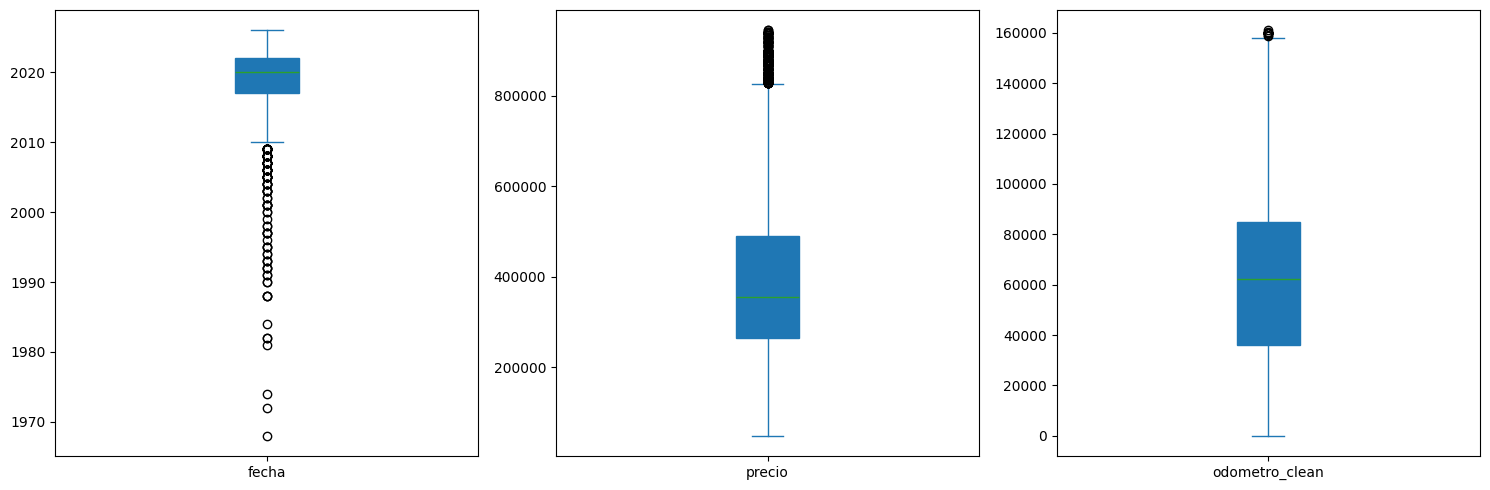

In [198]:
box_cols = seminuevos_fe_df[numerical_columns]

fig, axes = plt.subplots(1, len(numerical_columns), figsize=(5 * len(numerical_columns), 5))
axes = axes.ravel()

for col, ax in zip(numerical_columns, axes):
    box_cols[col].plot(kind='box', ax=ax, patch_artist=True)

plt.tight_layout()
plt.show()

In [199]:
seminuevos_fe_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
carroceria,7959,20,Camioneta SUV,3486,NaN,NaN,NaN,NaN,NaN,NaN,NaN
color,7959,45,Blanco,3573,NaN,NaN,NaN,NaN,NaN,NaN,NaN
combustible,7959,4,Gasolina,7584,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fecha,7959.0,NaN,NaN,NaN,2019.24777,3.940201,1968.0,2017.0,2020.0,2022.0,2026.0
marca,7959,60,Chevrolet,849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precio,7959.0,NaN,NaN,NaN,396952.168991,181416.904845,49000.0,265000.0,355000.0,489900.0,944900.0
odometro_clean,7959.0,NaN,NaN,NaN,61865.98394,34272.759922,0.0,36000.0,62100.0,85000.0,161000.0


CAPAZ VALE LA PENA DEJAR LOS OUTLIERS PORQUE CREO QUE ESTOY MEIENDO SESGO LIMITANDO:
* FECHA A COCHES DE 2012-2026
* PRECIO: 54564-957000
* KM: 0-157,000


# **Parte 2**. Ingeniería de características

## Transformando variables numéricas

NOTAS DE CLASE:

La distribución de las variables determinará que método usar y en qué orden. Por ejemplo, en variables sesgadas se debe realizar primero la transformación  y luego el escalamiento, ya que el efecto deseado es "desinclinar" las distribuciones del eje y ese efecto se maximiza cuando aplica en el rango completo en comparación con aplicarlo en variables con una desviación estándar unitaria (por z-score) o variables en el rango [0,1] (por Min-Max).

Aplicar es escalamiento antes comprimiría la mayoría de los datos en un rango estrecho. Entonces se debe iniciar con transformar la característica en Gaussiana y luego escalarla.

5a) Genera gráficos Q-Q de las variables NUMERICAS para observar las diferencias entre sus distribuciones y la normal.Las transformaciones *Box-Cox* y *Yeo-Johnson* son generalizaciones, pues incluyen casos especiales de transformaciones: logarítmica (`λ = 0`), recíproca (`λ = -1`),  raíz cuadrada (`λ = 0.5`) y más exponentes. En *Box-Cox* se evalúan varios valores de `λ` y se selecciona aquel que arroja la mejor transformación

La transformación de *Yeo-Johnson* es una extensión de la transformación de *Box-Cox* que ya no está restringida a valores positivos. En otras palabras, la transformación de *Yeo-Johnson* se puede utilizar en variables con valores cero y negativos, así como valores positivos. Cuando la variable solo tiene valores positivos, la transformación de *Yeo-Johnson* es como la transformación de *Box-Cox* de la variable más uno.

En este caso, como las variables `price` y `odometer` tienen valores de 0, utilizaremos *Yeo-Johnson*.

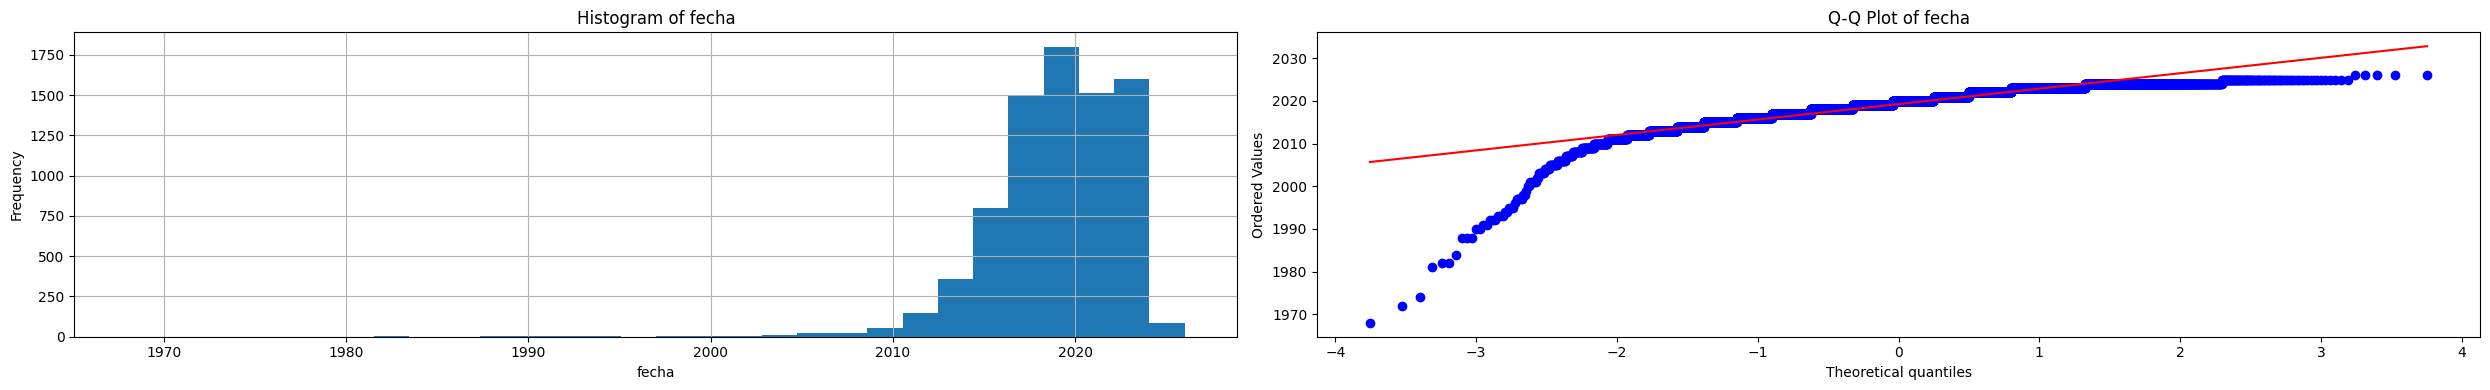

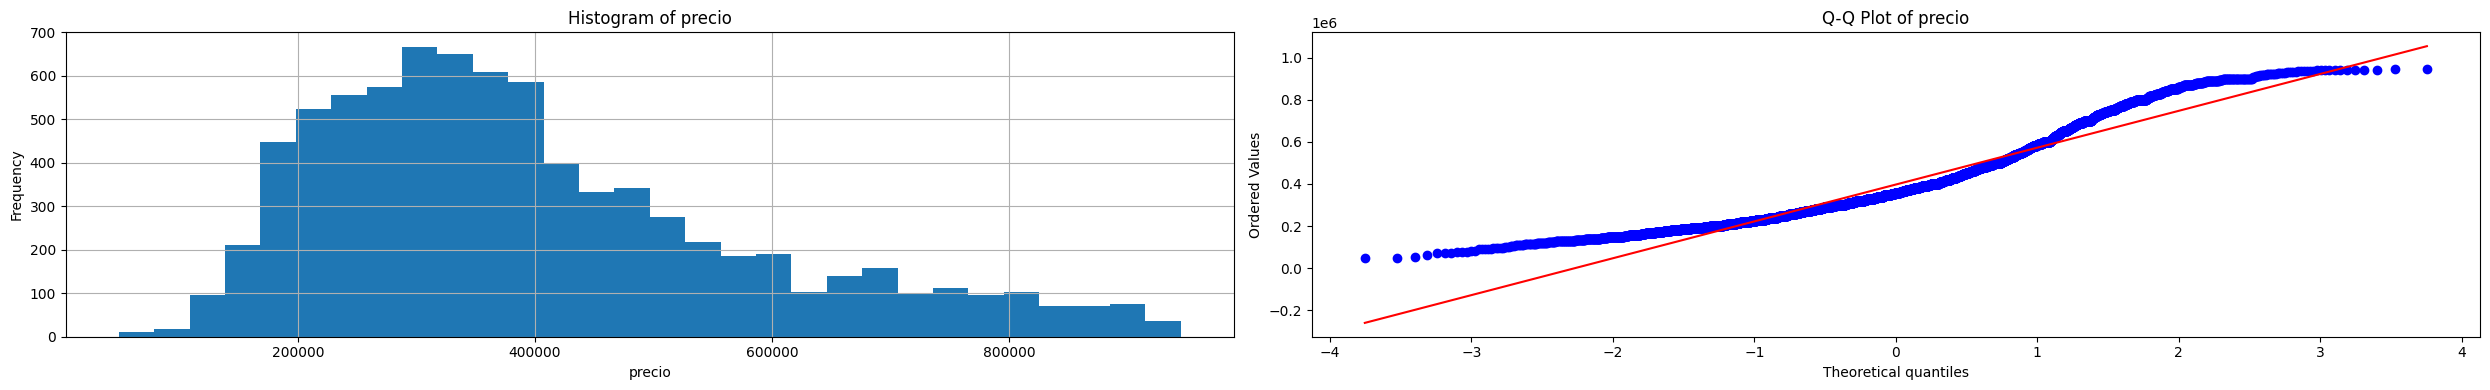

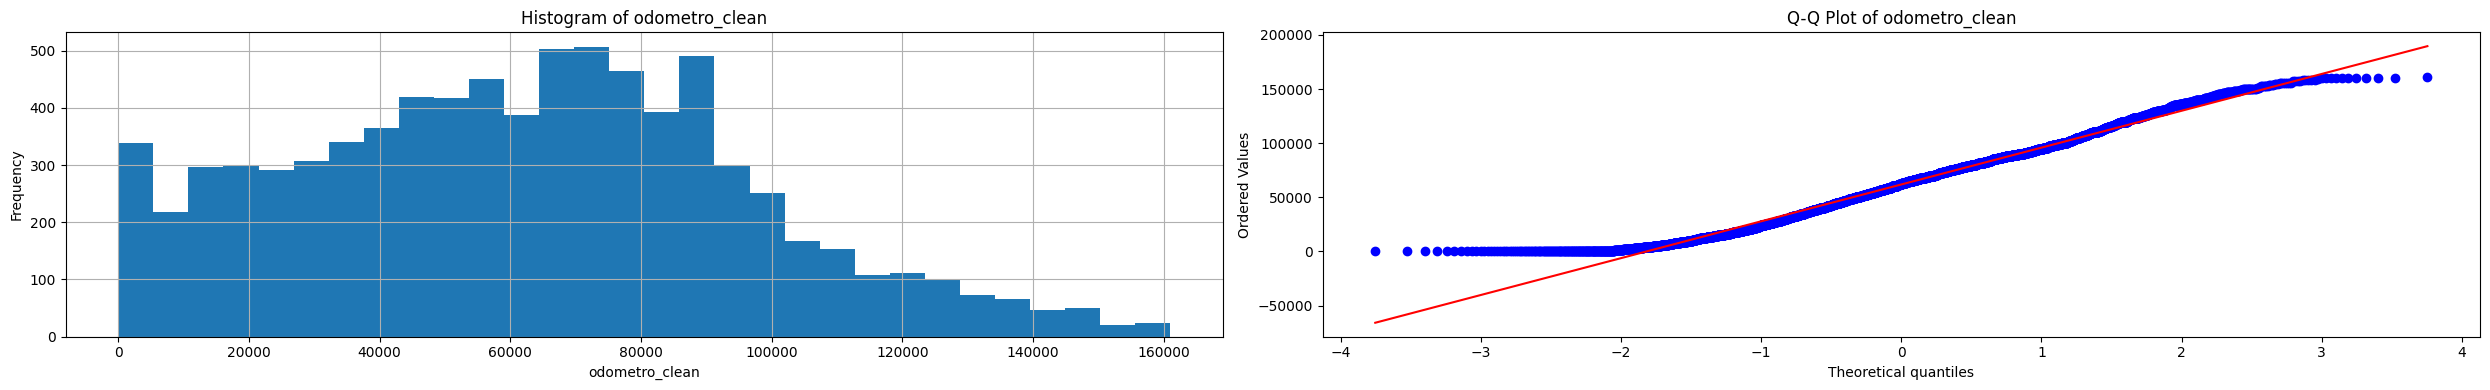

In [200]:
for variable in numerical_columns:
        plt.figure(figsize=(25, 4))

        # Histograma
        plt.subplot(1, 2, 1)
        seminuevos_fe_df[variable].hist(bins=30)
        plt.title(f"Histogram of {variable}")
        plt.xlabel(variable)
        plt.ylabel("Frequency")

        # Q-Q Plot
        plt.subplot(1, 2, 2)
        stats.probplot(seminuevos_fe_df[variable], dist="norm", plot=plt)
        plt.title(f"Q-Q Plot of {variable}")

        plt.tight_layout()
        plt.show()

TRANSFORMACION Y ESCALAMIENTO

* PRECIO- YEOJOHNSON
* ODOMETRO- YEO JOHNSON (HAY VALORES 0) Y STANDARRD SCALER PORQUE ES MENOS SENSIBLE A OUTLIERS QUE MIN MAX POR EJEMPLO
* FECHA ES CLARO QUE HAY QUE HACER BIINING

# **PARTE 1. PREPROCESAMIENTO CATEGORICAS**

In [201]:
seminuevos_fe_df.nunique()

,0
carroceria,20
color,45
combustible,4
fecha,44
marca,60
precio,1473
odometro_clean,3989


**FECHA-EDAD-BINNING**

In [202]:
#No queremos eliminar fechas, y por el histograma de si eliminamos los outliers nos damos cuenta que mejor BINNING
seminuevos_fe_df['edad_auto'] = 2026 - seminuevos_fe_df['fecha'].astype(int)

bins = [0, 3, 7, 12, 100]
labels = ['0-3 años', '4-7 años', '8-12 años', '13+ años']

seminuevos_fe_df['edad_auto_bin'] = pd.cut(seminuevos_fe_df['edad_auto'], bins=bins, labels=labels, right=True)

In [203]:
seminuevos_fe_df.dtypes

,0
carroceria,object
color,object
combustible,object
fecha,float64
marca,object
precio,float64
odometro_clean,float64
edad_auto,int64
edad_auto_bin,category


In [204]:
categorical_columns = seminuevos_fe_df.select_dtypes(include=['object', 'category']).columns

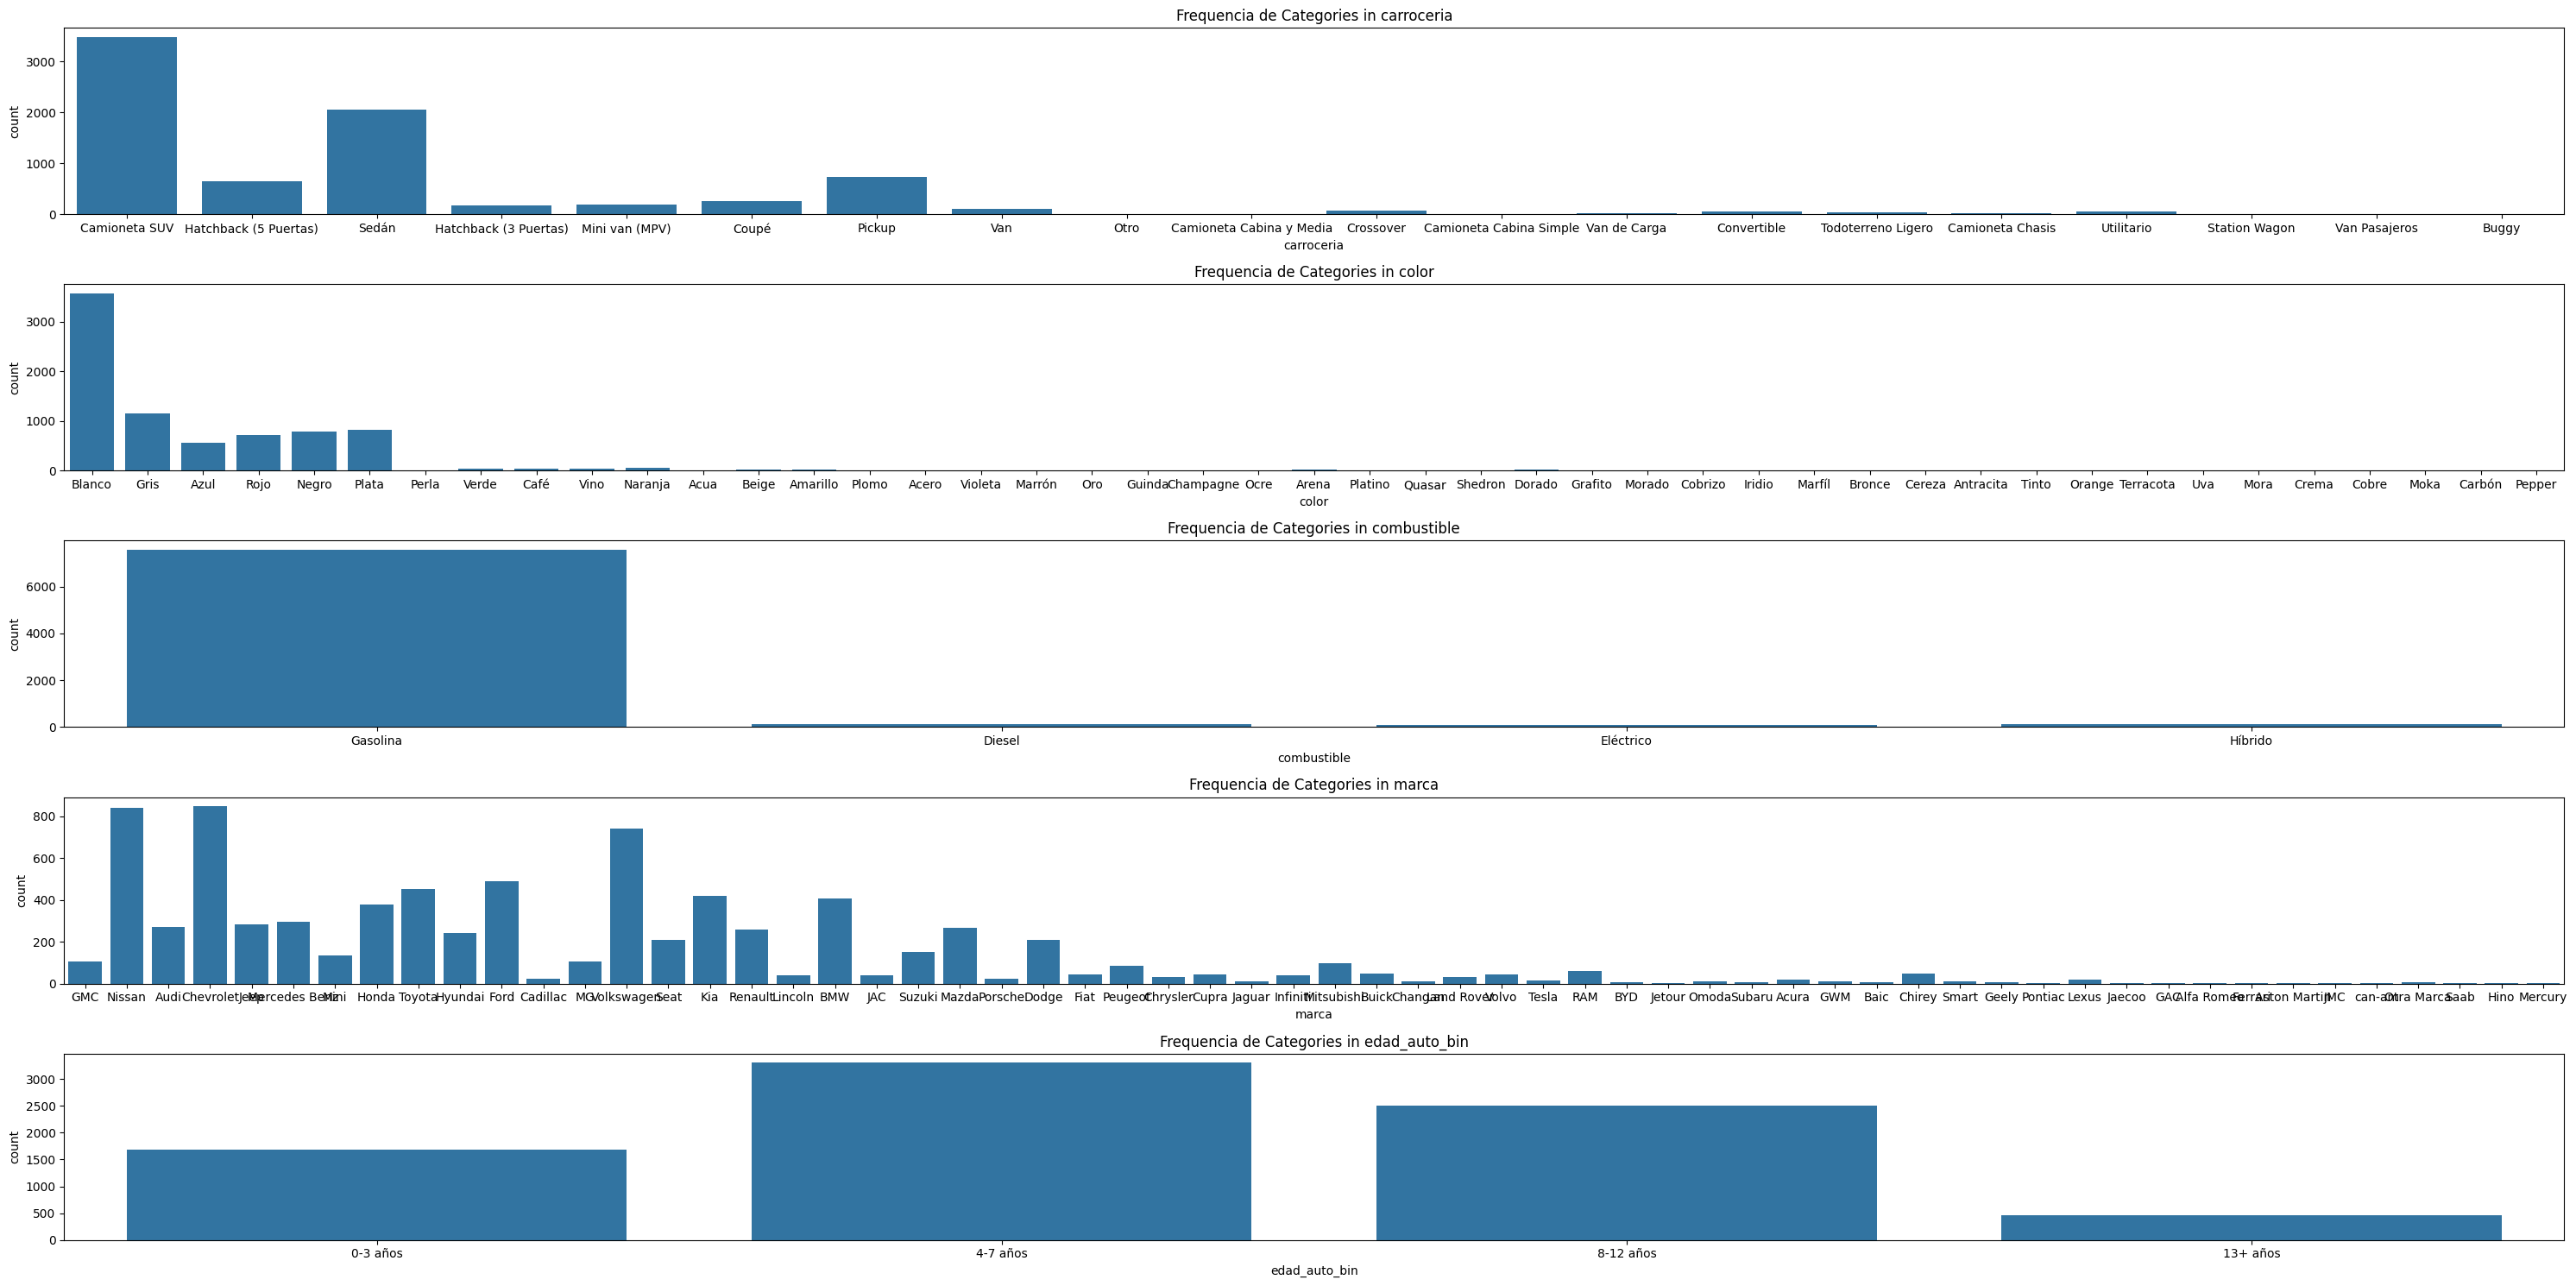

In [205]:
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(30, 2 * len(categorical_columns) + 5))
for i, col in enumerate(categorical_columns):
    # Bar
    sns.countplot(x=col, data=seminuevos_fe_df, ax=axes[i])
    axes[i].set_title(f'Frequencia de Categories in {col}')
plt.tight_layout()
plt.show()

**CARROCERIA LIMPIEZA**

In [206]:
def agrupar_carroceria(valor):
    if valor in ['Camioneta SUV', 'Crossover', 'Todoterreno Ligero']:
        return 'SUV'
    elif valor in ['Hatchback (5 Puertas)', 'Hatchback (3 Puertas)']:
        return 'Hatchback'
    elif valor == 'Sedán':
        return 'Sedán'
    elif valor == 'Pickup':
        return 'Pickup'
    elif valor in ['Van', 'Van de Carga', 'Van Pasajeros']:
        return 'Van'
    elif valor in ['Mini van (MPV)']:
        return 'Minivan'
    elif valor in ['Convertible', 'Coupé']:
        return 'Deportivo'
    elif valor in ['Camioneta Cabina Media', 'Camioneta Cabina Simple', 'Camioneta Chasis']:
        return 'Camioneta'
    elif valor == 'Station Wagon':
        return 'Familiar'
    elif valor in ['Utilitario', 'Buggy', 'Otro']:
        return 'Otro'
    else:
        return 'Otro'  # catch-all para categorías desconocidas

# Crear nueva columna agrupada
seminuevos_fe_df['carroceria_cat'] = seminuevos_fe_df['carroceria'].apply(agrupar_carroceria)


**COLOR AGRUPADO EN CATEGORIAS**

In [207]:
def agrupar_color(color):
    color = color.lower()
    if color in ['blanco', 'perla', 'marfil', 'crema']:
        return 'Blanco'
    elif color in ['gris', 'plata', 'plomo', 'acero', 'antracita']:
        return 'Gris/Plata'
    elif color in ['negro', 'carbón']:
        return 'Negro'
    elif color in ['rojo', 'guinda', 'vino', 'tinto', 'mora']:
        return 'Rojo/Burdeos'
    elif color in ['azul', 'acua', 'quasar']:
        return 'Azul'
    elif color in ['verde', 'uva']:
        return 'Verde'
    elif color in ['café', 'marrón', 'cobre', 'moka', 'cobrizo']:
        return 'Marrón'
    elif color in ['amarillo', 'dorado', 'oro', 'champagne', 'terracota', 'arena', 'ocre', 'beige']:
        return 'Amarillo/Dorado'
    elif color in ['naranja', 'orange']:
        return 'Naranja'
    elif color in ['morado', 'violeta']:
        return 'Morado'
    else:
        return 'Otro' # CAPAZ PODRIAMOS MANDAR ESTO Verde, marron, amarillo/dorado

# Aplicar transformación
seminuevos_fe_df['color_CAT'] = seminuevos_fe_df['color'].apply(agrupar_color)

**COMBUSTIBLE**
Crear una variable binaria
* 1 = Convencional (Gasolina o Diésel)
* 0 = Alternativo (Eléctrico o Híbrido)

In [208]:
seminuevos_fe_df['combustible_bin'] = seminuevos_fe_df['combustible'].apply(
    lambda x: 1 if x in ['Gasolina', 'Diésel'] else 0
)

In [209]:
seminuevos_fe_df['marca'].unique()

array(['GMC', 'Nissan', 'Audi', 'Chevrolet', 'Jeep', 'Mercedes Benz',
       'Mini', 'Honda', 'Toyota', 'Hyundai', 'Ford', 'Cadillac', 'MG',
       'Volkswagen', 'Seat', 'Kia', 'Renault', 'Lincoln', 'BMW', 'JAC',
       'Suzuki', 'Mazda', 'Porsche', 'Dodge', 'Fiat', 'Peugeot',
       'Chrysler', 'Cupra', 'Jaguar', 'Infiniti', 'Mitsubishi', 'Buick',
       'Changan', 'Land Rover', 'Volvo', 'Tesla', 'RAM', 'BYD', 'Jetour',
       'Omoda', 'Subaru', 'Acura', 'GWM', 'Baic', 'Chirey', 'Smart',
       'Geely', 'Pontiac', 'Lexus', 'Jaecoo', 'GAC', 'Alfa Romeo',
       'Ferrari', 'Aston Martin', 'JMC', 'can-am', 'Otra Marca', 'Saab',
       'Hino', 'Mercury'], dtype=object)

**LIMPIEZA MARCA:**


Asigna a cada marca su precio promedio, creando una variable numérica ordenada por el valor real que tiene cada marca en el mercado.

In [210]:
# Calcular el promedio de precio por marca
mean_price_by_brand = seminuevos_fe_df.groupby('marca')['precio'].mean()

# Mapear ese promedio al DataFrame
seminuevos_fe_df['marca_encoded'] = seminuevos_fe_df['marca'].map(mean_price_by_brand)


In [211]:
seminuevos_fe_df['marca_encoded'].unique()

array([500905.15238095, 333518.22235434, 487247.05535055, 336473.26383981,
       462424.33096085, 530278.29152542, 463000.94117647, 372543.73015873,
       430847.96452328, 355339.0781893 , 472016.46435845, 532806.52173913,
       325115.87850467, 348551.6734143 , 365414.64285714, 336376.90191388,
       267139.33203125, 472963.41463415, 545647.97297297, 346411.175     ,
       290320.12751678, 364823.92481203, 694904.76190476, 362303.9178744 ,
       219904.44444444, 329611.61627907, 339777.41935484, 703276.        ,
       614800.        , 498103.89473684, 371965.45360825, 439683.58333333,
       264294.44444444, 606025.86206897, 568022.72727273, 746577.93333333,
       482673.09836066, 679942.85714286, 519500.        , 370650.75      ,
       599980.        , 441905.26315789, 667877.77777778, 290266.66666667,
       399830.3877551 , 178108.33333333, 468955.2       ,  93500.        ,
       772379.95      , 589800.        , 583300.        , 647475.        ,
       589000.        ,  

In [212]:
categorical_columns = seminuevos_fe_df.select_dtypes(include=['object', 'category']).columns

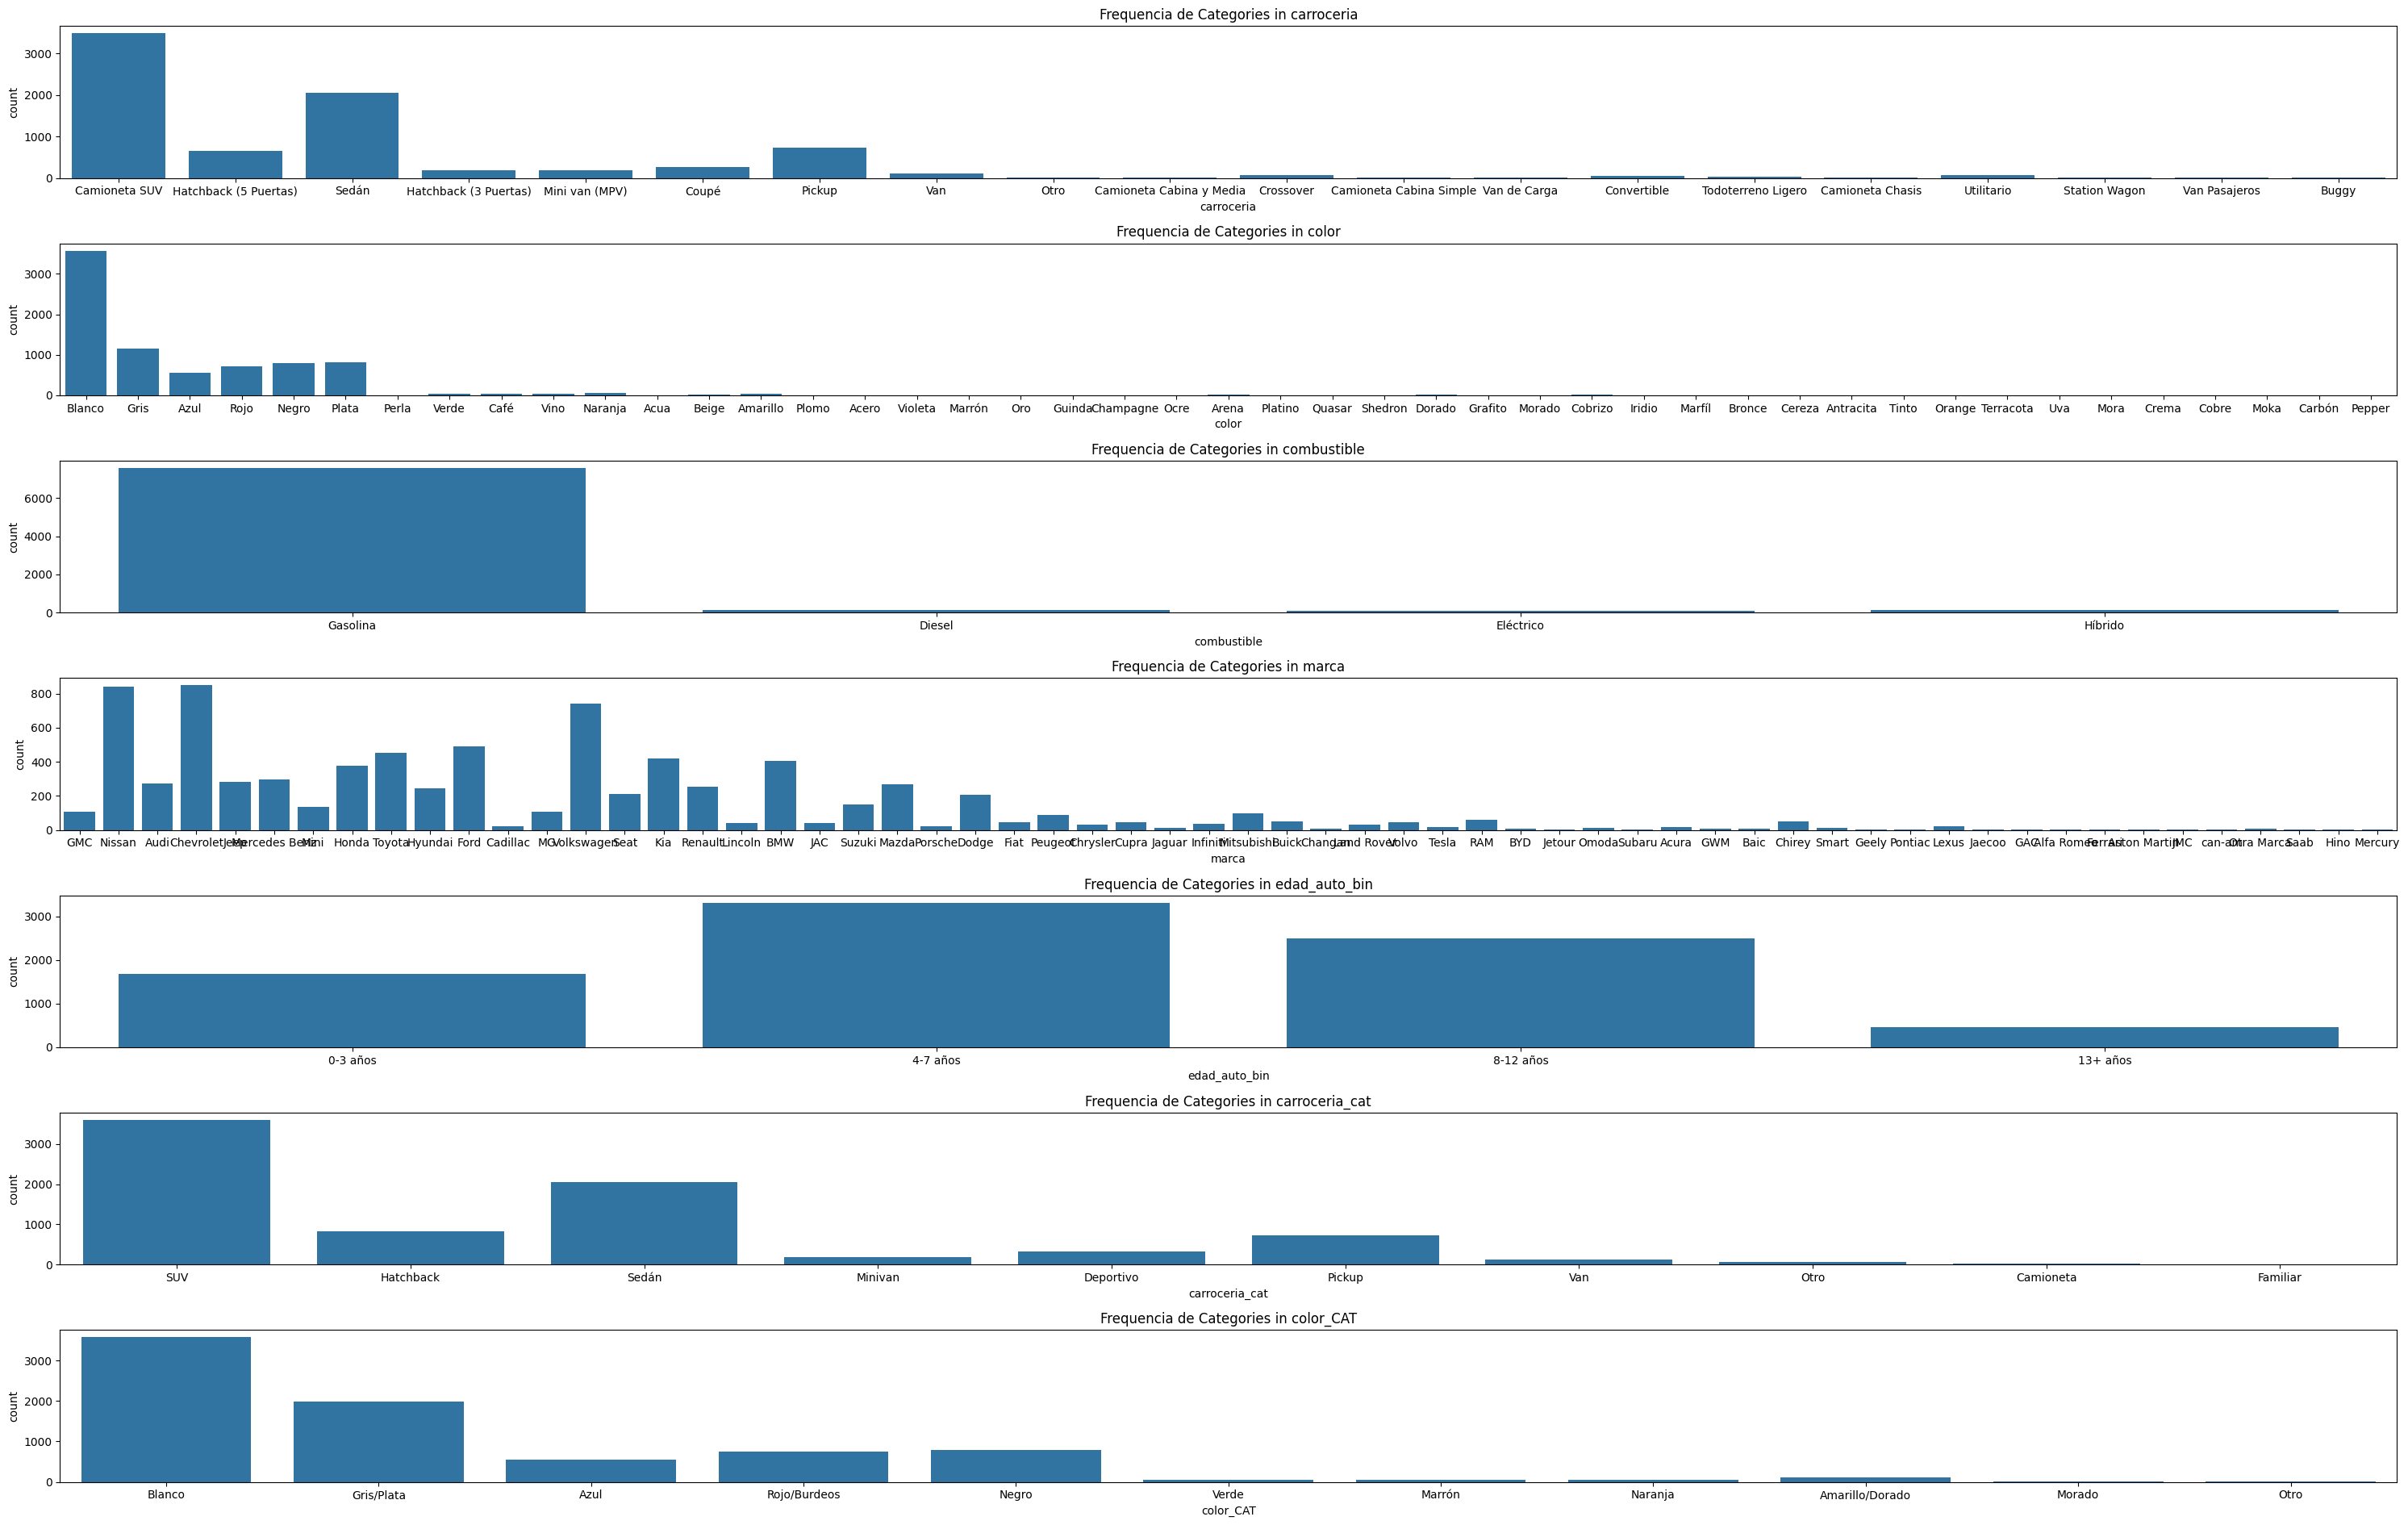

In [213]:
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(30, 2 * len(categorical_columns) + 5))
for i, col in enumerate(categorical_columns):
    # Bar
    sns.countplot(x=col, data=seminuevos_fe_df, ax=axes[i])
    axes[i].set_title(f'Frequencia de Categories in {col}')
plt.tight_layout()
plt.show()

**ONE HOT | BINARIA | ORDINAL**

In [214]:
seminuevos_fe_df.nunique()

,0
carroceria,20
color,45
combustible,4
fecha,44
marca,60
precio,1473
odometro_clean,3989
edad_auto,44
edad_auto_bin,4
carroceria_cat,10


In [215]:
seminuevos_fe_df.dtypes

,0
carroceria,object
color,object
combustible,object
fecha,float64
marca,object
precio,float64
odometro_clean,float64
edad_auto,int64
edad_auto_bin,category
carroceria_cat,object


In [216]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
import numpy as np

# Columnas por tipo
onehot_cols = ['edad_auto_bin', 'carroceria_cat', 'color_CAT']
binary_cat_col = 'combustible_bin'
standard_scaled_col = 'marca_encoded'
boxcox_col = 'precio'
yeojohnson_col = 'odometro_clean'

# ColumnTransformer final
preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_cols),
    ('binary', 'passthrough', [binary_cat_col]),
    ('standard', StandardScaler(), [standard_scaled_col]),
    ('boxcox', PowerTransformer(method='box-cox'), [boxcox_col]),
    ('yeojohnson', Pipeline([
        ('yeojohnson', PowerTransformer(method='yeo-johnson')),
        ('scaler', StandardScaler())
    ]), [yeojohnson_col])
])

# Fit-transform the data
X_transformed = preprocessor.fit_transform(seminuevos_fe_df)

# Obtener nombres one-hot
onehot_feature_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(onehot_cols)

# Nombres manuales para columnas que no generan múltiples
other_feature_names = ['combustible_bin', 'marca_encoded_scaled', 'precio_boxcox', 'odometro_clean_scaled']

# Juntar todos
column_names = list(onehot_feature_names) + other_feature_names

# Verificación
print("Shape:", X_transformed.shape)
print("Column count:", len(column_names))

Shape: (7959, 30)
Column count: 30


In [217]:
assert X_transformed.shape[1] == len(column_names), "Mismatch entre columnas transformadas y nombres"

# Convertir a DataFrame (aunque tecnicamente incluye la y pero quiero ver como sale la correlacion )
X_transformed_df = pd.DataFrame(X_transformed, columns=column_names)

In [218]:
X_transformed_df.dtypes

,0
edad_auto_bin_0-3 años,float64
edad_auto_bin_13+ años,float64
edad_auto_bin_4-7 años,float64
edad_auto_bin_8-12 años,float64
edad_auto_bin_nan,float64
carroceria_cat_Camioneta,float64
carroceria_cat_Deportivo,float64
carroceria_cat_Familiar,float64
carroceria_cat_Hatchback,float64
carroceria_cat_Minivan,float64


In [219]:
correlation_matrix = X_transformed_df.corr(method='pearson')
correlation_matrix

,edad_auto_bin_0-3 años,edad_auto_bin_13+ años,edad_auto_bin_4-7 años,edad_auto_bin_8-12 años,edad_auto_bin_nan,carroceria_cat_Camioneta,carroceria_cat_Deportivo,carroceria_cat_Familiar,carroceria_cat_Hatchback,carroceria_cat_Minivan,...,color_CAT_Morado,color_CAT_Naranja,color_CAT_Negro,color_CAT_Otro,color_CAT_Rojo/Burdeos,color_CAT_Verde,combustible_bin,marca_encoded_scaled,precio_boxcox,odometro_clean_scaled
edad_auto_bin_0-3 años,1.000000,-0.128358,-0.436746,-0.349810,-0.012964,-0.010625,-0.047044,-0.012964,-0.049840,-0.050854,...,-0.008198,0.016347,0.027133,-0.008585,0.027140,0.033703,-0.033271,-0.097330,0.233580,-0.622296
edad_auto_bin_13+ años,-0.128358,1.000000,-0.209682,-0.167944,-0.006224,-0.003354,0.075832,0.015221,0.025824,0.033321,...,-0.003936,-0.020708,-0.014120,0.018655,-0.027547,-0.004750,0.034914,0.036599,-0.301739,0.226827
edad_auto_bin_4-7 años,-0.436746,-0.209682,1.000000,-0.571439,-0.021178,0.002009,-0.036485,-0.000833,-0.023685,-0.014611,...,0.002689,0.024918,0.015392,-0.003697,0.012986,-0.007241,-0.051551,0.029429,0.207031,0.006681
edad_auto_bin_8-12 años,-0.349810,-0.167944,-0.571439,1.000000,-0.016962,0.008969,0.042177,0.004647,0.055537,0.043643,...,0.006354,-0.030291,-0.032637,0.002144,-0.023332,-0.019440,0.066111,0.035628,-0.273824,0.425943
edad_auto_bin_nan,-0.012964,-0.006224,-0.021178,-0.016962,1.000000,-0.001350,-0.005106,-0.000629,0.007823,-0.003857,...,-0.000397,-0.002091,-0.008323,-0.001290,-0.008140,-0.001912,0.005575,0.004341,0.011415,-0.005128
carroceria_cat_Camioneta,-0.010625,-0.003354,0.002009,0.008969,-0.001350,1.000000,-0.010965,-0.001350,-0.018394,-0.008282,...,-0.000853,-0.004491,-0.002215,-0.002769,-0.001541,-0.004105,0.011971,-0.002586,0.027965,0.029386
carroceria_cat_Deportivo,-0.047044,0.075832,-0.036485,0.042177,-0.005106,-0.010965,1.000000,-0.005106,-0.069588,-0.031332,...,-0.003229,0.014033,0.009744,0.002049,0.008246,0.018374,0.030128,0.102215,0.056730,-0.005757
carroceria_cat_Familiar,-0.012964,0.015221,-0.000833,0.004647,-0.000629,-0.001350,-0.005106,1.000000,-0.008566,-0.003857,...,-0.000397,-0.002091,-0.008323,-0.001290,-0.008140,-0.001912,0.005575,-0.027147,-0.038807,-0.002689
carroceria_cat_Hatchback,-0.049840,0.025824,-0.023685,0.055537,0.007823,-0.018394,-0.069588,-0.008566,1.000000,-0.052561,...,-0.005417,-0.008672,0.004693,-0.001563,0.009308,0.017289,-0.003487,-0.042392,-0.214610,-0.004418
carroceria_cat_Minivan,-0.050854,0.033321,-0.014611,0.043643,-0.003857,-0.008282,-0.031332,-0.003857,-0.052561,1.000000,...,-0.002439,-0.002740,-0.045475,-0.007912,-0.027175,-0.011729,-0.044708,-0.014431,0.007640,0.071960


<Axes: >

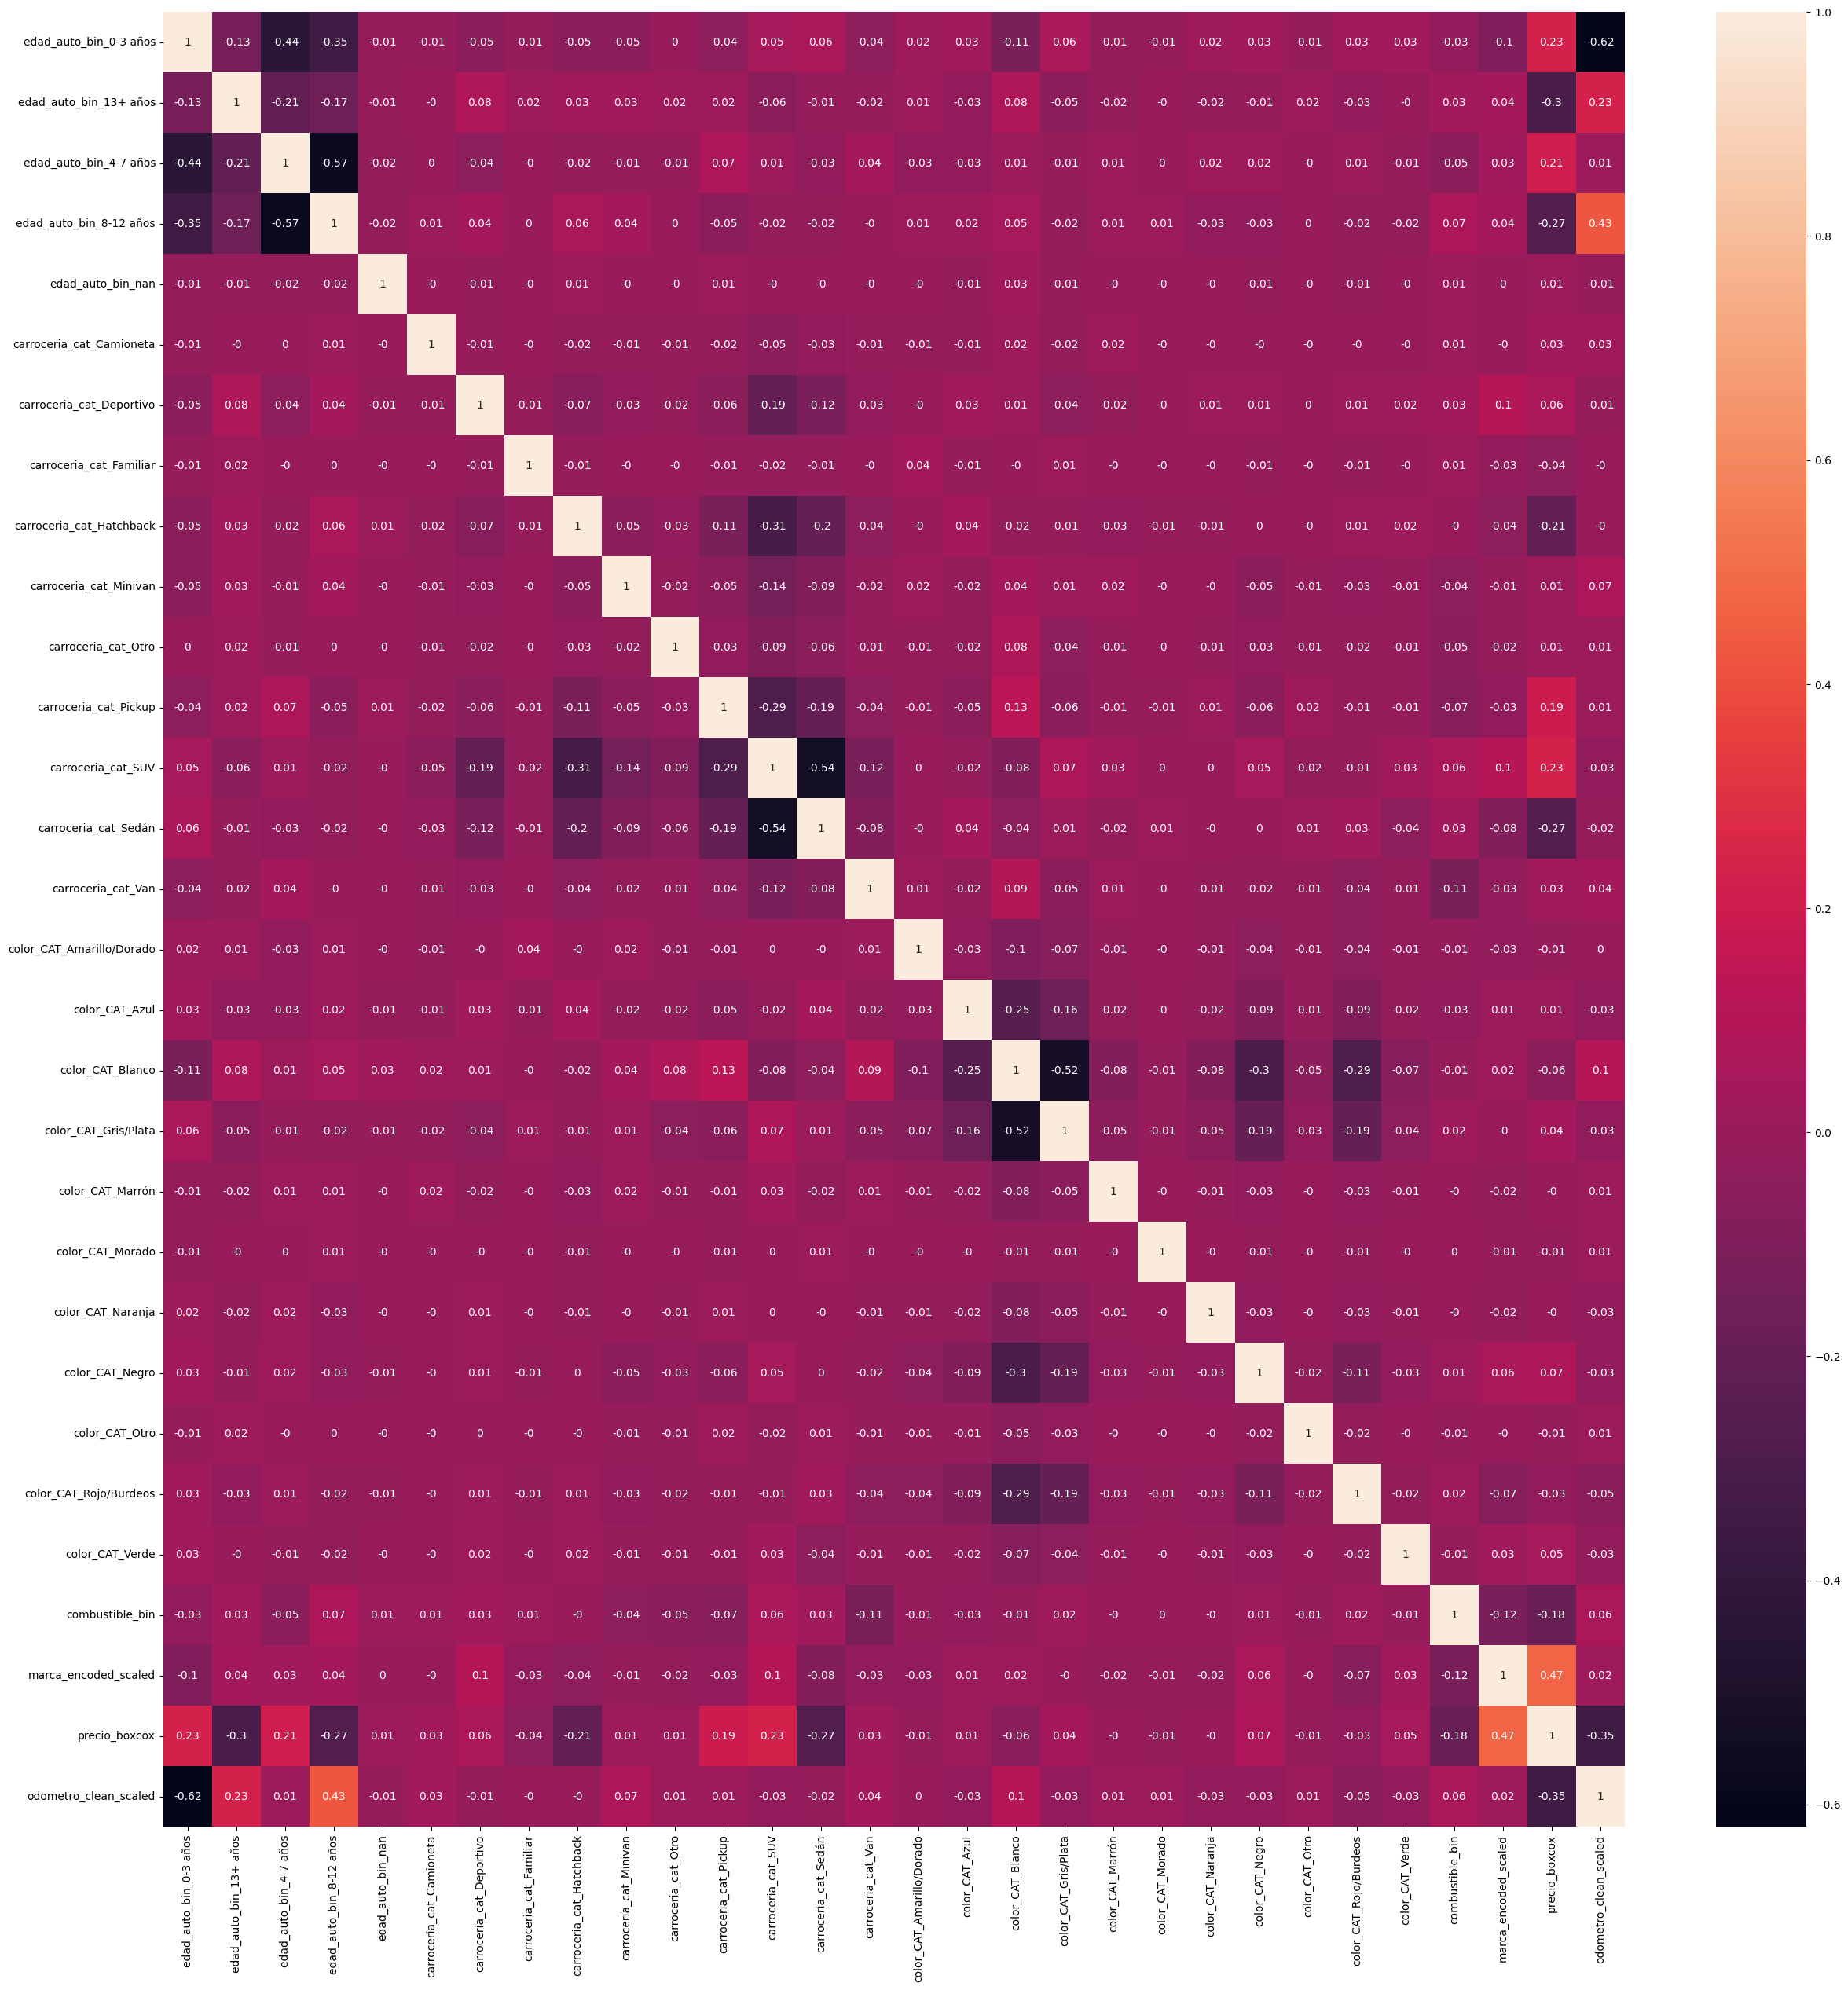

In [220]:
plt.rcParams['figure.figsize'] = (30, 30)
sns.heatmap(round(correlation_matrix,2), annot=True)

# **CONCLUSIONES**

**RIESGOS QUE ATENDER PARA EL SIGUIENTE AVANCE ANTES DEL MODELO**

* OVERFITTING POR COLOR Y CARROCERIA
* MULTICOLINEALIDAD ENTRE EDAD Y ODOMETRO
* COLOR: BLANCO Y PLATA MUCHA CORRELACIÓN QUIZAS PODRIAMOS RECLASIFICAR LOS COLORES
* MARCA PARECE SER NUESTRO MEJOR PREDICTOR
* QUIZAS SEA BUENA IDEA APLICAR A CARROCERIA- PROMEDIO POR TIPO-Y UN STANDARD SCALER